2.16.1
epoch: 1/5000, d_loss: 0.71, d_acc: 0.53, g_loss: 0.67
epoch: 101/5000, d_loss: 0.05, d_acc: 1.00, g_loss: 3.26
epoch: 201/5000, d_loss: 0.62, d_acc: 0.53, g_loss: 1.26
epoch: 301/5000, d_loss: 0.66, d_acc: 0.47, g_loss: 0.65
epoch: 401/5000, d_loss: 0.69, d_acc: 0.48, g_loss: 0.75
epoch: 501/5000, d_loss: 0.69, d_acc: 0.55, g_loss: 0.66
epoch: 601/5000, d_loss: 0.67, d_acc: 0.62, g_loss: 0.68
epoch: 701/5000, d_loss: 0.69, d_acc: 0.61, g_loss: 0.62
epoch: 801/5000, d_loss: 0.70, d_acc: 0.52, g_loss: 0.57
epoch: 901/5000, d_loss: 0.67, d_acc: 0.55, g_loss: 0.68
epoch: 1001/5000, d_loss: 0.68, d_acc: 0.50, g_loss: 0.66
epoch: 1101/5000, d_loss: 0.66, d_acc: 0.70, g_loss: 0.76
epoch: 1201/5000, d_loss: 0.67, d_acc: 0.56, g_loss: 0.88
epoch: 1301/5000, d_loss: 0.62, d_acc: 0.73, g_loss: 0.80
epoch: 1401/5000, d_loss: 0.60, d_acc: 0.69, g_loss: 0.95
epoch: 1501/5000, d_loss: 0.59, d_acc: 0.73, g_loss: 0.96
epoch: 1601/5000, d_loss: 0.67, d_acc: 0.58, g_loss: 0.81
epoch: 1701/5000, d

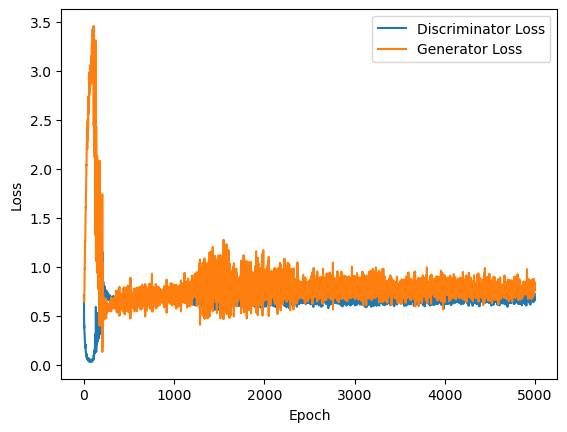

In [ ]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

latent_dim = 100

def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)
    model = Model(i, x)
    return model

def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

discriminator = build_discriminator(D)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
generator = build_generator(latent_dim)

z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)
combined_model_gen = Model(z, fake_pred)
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
batch_size = 32
epochs = 5000
sample_period = 200

ones = np.ones((batch_size, 1), dtype=np.float32)
zeros = np.zeros((batch_size, 1), dtype=np.float32)
d_losses = []
g_losses = []

if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator(noise, training=False)
    imgs = 0.5 * imgs + 0.5
    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(tf.reshape(imgs[idx], (H, W)).numpy(), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig(f"gan_images/{epoch}.png")
    plt.close()

@tf.function
def train_discriminator(real_imgs, fake_imgs, ones, zeros):
    discriminator.trainable = True
    with tf.GradientTape() as tape:
        real_pred = discriminator(real_imgs, training=True)
        d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(ones, real_pred))
        fake_pred = discriminator(fake_imgs, training=True)
        d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(zeros, fake_pred))
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
    real_acc = tf.reduce_mean(tf.cast(tf.round(real_pred) == ones, tf.float32))
    fake_acc = tf.reduce_mean(tf.cast(tf.round(fake_pred) == zeros, tf.float32))
    d_acc = 0.5 * (real_acc + fake_acc)
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator.optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    discriminator.trainable = False
    return d_loss, d_acc

@tf.function
def train_generator(noise, ones):
    with tf.GradientTape() as tape:
        fake_imgs = generator(noise, training=True)
        fake_pred = discriminator(fake_imgs, training=False)
        g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(ones, fake_pred))
    grads = tape.gradient(g_loss, generator.trainable_variables)
    combined_model_gen.optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    return g_loss

for epoch in range(epochs):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator(noise, training=False)
    d_loss, d_acc = train_discriminator(real_imgs, fake_imgs, ones, zeros)
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = train_generator(noise, ones)
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = train_generator(noise, ones)
    d_losses.append(d_loss.numpy())
    g_losses.append(g_loss.numpy())
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
    if epoch % sample_period == 0:
        sample_images(epoch)

plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
